In [120]:
import re
import os
import shutil
import time
import zipfile
from pathlib import PurePath
from tqdm.notebook import tqdm

import logging
from gensim.models.word2vec import Word2Vec

import ncbi.datasets
from ncbi.datasets.openapi import ApiException

from Bio import SeqIO

import pandas as pd

from IPython.display import clear_output
from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns

from jupyterthemes import jtplot
jtplot.style(theme='chesterish', context='notebook', ticks=True, grid=False)

In [3]:
MAX_PER_PAGE =1000

# Get Genomes

In [39]:
#start api 
api_instance = ncbi.datasets.GenomeApi(ncbi.datasets.ApiClient())

#get first assemblies and token for next page
genome_summary = api_instance.assembly_descriptors_by_taxon(
    taxon=562 , 
    page_size=MAX_PER_PAGE)
token = genome_summary.next_page_token

#get assemblies and tokens until there is no token and save to summaries dict
summaries = {}
pbar = tqdm(total=genome_summary.total_count)
while token:
    summaries[token] = genome_summary
    try:
        genome_summary = api_instance.assembly_descriptors_by_taxon(
                                                                    taxon=562 ,
                                                                    page_size=MAX_PER_PAGE,
                                                                    page_token=token
                                                                    )
    except ApiException as e:
        wait = 15
        print(f'{e} waiting {wait}s')
        time.sleep(wait)
        continue
        
    pbar.update(len(genome_summary.assemblies))
    token = genome_summary.next_page_token

  5%|▍         | 7000/152234 [00:19<06:43, 359.99it/s]

(504)
Reason: Gateway Timeout
HTTP response headers: HTTPHeaderDict({'Date': 'Sun, 11 Jul 2021 18:29:23 GMT', 'Server': 'Apache', 'Strict-Transport-Security': 'max-age=31536000; includeSubDomains; preload', 'Content-Security-Policy': 'upgrade-insecure-requests', 'Ncbi-Phid': '939B4489D254C1D5000054ACBF49DF2C.1.1', 'Content-Length': '230', 'X-Datasets-Version': '12.3.0', 'Content-Type': 'application/json', 'Vary': 'Accept-Encoding', 'X-UA-Compatible': 'IE=Edge', 'X-XSS-Protection': '1; mode=block'})
HTTP response body: {"error":"Gateway Timeout","code":504,"message":"Internal server error - request timed out (For more help, see the NCBI Datasets Documentation at https://www.ncbi.nlm.nih.gov/datasets/docs/) (939B4489D254C1D5000054ACBF49DF2C.1)"}

 waiting 15s


 12%|█▏        | 19000/152234 [01:10<07:21, 301.59it/s]

(504)
Reason: Gateway Timeout
HTTP response headers: HTTPHeaderDict({'Date': 'Sun, 11 Jul 2021 18:30:14 GMT', 'Server': 'Apache', 'Strict-Transport-Security': 'max-age=31536000; includeSubDomains; preload', 'Content-Security-Policy': 'upgrade-insecure-requests', 'Ncbi-Phid': 'D0BD40F51D9A9365000047A46DE10779.1.1', 'Content-Length': '230', 'X-Datasets-Version': '12.3.0', 'Content-Type': 'application/json', 'Vary': 'Accept-Encoding', 'X-UA-Compatible': 'IE=Edge', 'X-XSS-Protection': '1; mode=block'})
HTTP response body: {"error":"Gateway Timeout","code":504,"message":"Internal server error - request timed out (For more help, see the NCBI Datasets Documentation at https://www.ncbi.nlm.nih.gov/datasets/docs/) (D0BD40F51D9A9365000047A46DE10779.1)"}

 waiting 15s


 82%|████████▏ | 125000/152234 [06:00<00:51, 532.04it/s]

(504)
Reason: Gateway Timeout
HTTP response headers: HTTPHeaderDict({'Date': 'Sun, 11 Jul 2021 18:35:04 GMT', 'Server': 'Apache', 'Strict-Transport-Security': 'max-age=31536000; includeSubDomains; preload', 'Content-Security-Policy': 'upgrade-insecure-requests', 'Ncbi-Phid': '939B4489D254C1D5000047ADC65C0B3C.1.1', 'Content-Length': '230', 'X-Datasets-Version': '12.3.0', 'Content-Type': 'application/json', 'Vary': 'Accept-Encoding', 'X-UA-Compatible': 'IE=Edge', 'X-XSS-Protection': '1; mode=block'})
HTTP response body: {"error":"Gateway Timeout","code":504,"message":"Internal server error - request timed out (For more help, see the NCBI Datasets Documentation at https://www.ncbi.nlm.nih.gov/datasets/docs/) (939B4489D254C1D5000047ADC65C0B3C.1)"}

 waiting 15s


 99%|█████████▉| 151234/152234 [07:15<00:02, 478.06it/s]

In [40]:
len(summaries)

152

In [90]:
for genome_summary_inst in summaries.values():
    for assembly in map(lambda d: d.assembly, genome_summary_inst.assemblies):
            assm_table[assembly.assembly_accession] = {
            'assm_name': assembly.display_name,
            'org_name': assembly.org.title,
            'sci_name': assembly.org.sci_name,
            'assm_level': assembly.assembly_level,
            'num_chromosomes': n_chr,
            'contig_n50': assembly.contig_n50,
            'seq_length': assembly.seq_length,
            'submission_date': assembly.submission_date,
             'estimated_size': assembly.estimated_size}

df = pd.DataFrame.from_dict(assm_table, orient='index')
#df = df.transpose()
display(df)

,assm_name,org_name,sci_name,assm_level,num_chromosomes,contig_n50,seq_length,submission_date,estimated_size
GCF_000157115.2,Escherichia_sp_3_2_53FAA_V2,E. coli,Escherichia coli,Scaffold,None,213698,5153453,2015-07-15,7107687
GCF_000308975.1,ASM30897v2,E. coli,Escherichia coli,Scaffold,None,265118,4754148,2012-11-09,6496550
GCF_000597845.1,ASM59784v1,E. coli,Escherichia coli,Complete Genome,None,4758629,4758629,2014-03-19,6513981
GCF_000599625.1,ASM59962v1,E. coli,Escherichia coli,Complete Genome,None,4807977,4807977,2014-03-19,6564642
GCF_000599645.1,ASM59964v1,E. coli,Escherichia coli,Complete Genome,None,4875682,4875682,2014-03-19,6634296
...,...,...,...,...,...,...,...,...,...
GCA_000166555.2,ASM16655v2,Escherichia coli TW10722,Escherichia coli TW10722,Contig,None,135060,5689893,2010-11-15,1702369
GCA_000166575.2,ASM16657v2,Escherichia coli TW10828,Escherichia coli TW10828,Contig,None,208639,5280267,2010-11-15,1575716
GCA_000166595.2,ASM16659v2,Escherichia coli TW11681,Escherichia coli TW11681,Contig,None,132862,5305843,2010-11-15,1581153
GCA_018884445.1,ASM1888444v1,Escherichia coli TW11681,Escherichia coli TW11681,Chromosome,None,4936886,5283837,2021-06-15,1572018


In [129]:
df.to_csv('../output/coli_asm_df.csv')

In [21]:
df = pd.read_csv('../output/coli_asm_df.csv')
df = df.rename(columns={"Unnamed: 0": "Acc"})
df['acc_no_version']= df.apply(lambda x: '.'.join(str(x['Acc']).split('.')[:-1]),axis=1)

In [38]:
cat_df = pd.DataFrame(columns=df.columns)
for n,g in tqdm(df.groupby(['acc_no_version'])):
    if len(g)>1:
        g['acc_version']= g.apply(lambda x: int(str(x['Acc']).split('.')[-1]),axis=1)
        i = g['acc_version'].idxmax()
        g= g.loc[[i]]
        
    cat_df = pd.concat([cat_df,g],ignore_index=True)

100%|██████████| 151745/151745 [1:54:09<00:00, 22.15it/s]


In [ ]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

configuration = ncbi.datasets.openapi.Configuration(host = "https://api.ncbi.nlm.nih.gov/datasets/v1alpha")
configuration.api_key_prefix['api-key'] = 'Bearer'
pbar = tqdm(total = len(cat_df))
n=100
for i,chunk in enumerate(chunks(cat_df['Acc'].to_list(), n)):
    downloaded = False
    while not downloaded:
        with ncbi.datasets.openapi.ApiClient(configuration) as api_client:
            api_instance = ncbi.datasets.openapi.GenomeApi(api_client)
        try:
            api_response = api_instance.download_assembly_package(chunk,exclude_sequence=False, _preload_content=False)
        except ApiException as e:
            if e.status == 508:
                print(f"{e.reason} waiting 15s: {e}")
                time.sleep(15)
                continue
            elif e.status == 414:
                print(e.reason)
                break
            else:
                print('Couldnt handle exception')
                print(e)
                break
                
        downloaded = True
        with open(f'../input/{i}_genome.zip', 'wb') as f:
                f.write(api_response.data)
        pbar.update(n)

  0%|          | 0/151745 [00:00<?, ?it/s]

# Data Exploration

Assembly for each bacteria have multiple files: **chromosome**, **plasmid**, **unplaced scaffolds**.\
Some bacteria do not have proper naming eg. <ins>chromosome is named as unplaced scaffold</ins>.\
In order to utilize as much data as possible I will check if concatenating all files for a given bacteria will yiedl aproximately accuracte genome size of E. coli of around 4.6 Mbp.\
I will test this hypothesis on aproximately  10% of the data, which constitues roughly 15.2 thousand assemblies.

In [ ]:
!ls  ../input

In [30]:
def extractor(zip_file,new_dr):
    extension = 'fna'
    for file in zip_file.namelist():
        if file[-3:] == extension:
            zip_file.extract(file,new_dr) 

pbar = tqdm(total=152)
unziped = '../input/unziped'
sequence_length = {}
if not os.path.exists(unziped): os.mkdir(unziped)
for i,f in enumerate(os.listdir('../input/')):
    if os.path.exists(unziped+str(i)): shutil.rmtree(unziped+str(i))
    if i%152 == 0 and i!=0: break
    with zipfile.ZipFile(f'../input/{i}_genome.zip', 'r') as zip_ref:
        extractor(zip_ref,unziped+str(i))
        for rootd, dirs, files in os.walk(unziped+str(i)):
            if len(files)>0: #match = re.match("\w{3}_\w+\.\d_\w+\.fna",' '.join(files))
                for f in files:
                    #clear_output(wait=True)
                    #print(f)
                    cat_ctg_len = 0
                    with open(os.path.join(rootd,f),'r') as h:
                        for record in SeqIO.parse(h,'fasta'): 
                            cat_ctg_len +=len(record.seq)
                    sequence_length[PurePath(rootd).name] = cat_ctg_len
    pbar.update(1)

  0%|          | 0/152 [00:00<?, ?it/s]

In [121]:
subset_asm = list(sequence_length.values())

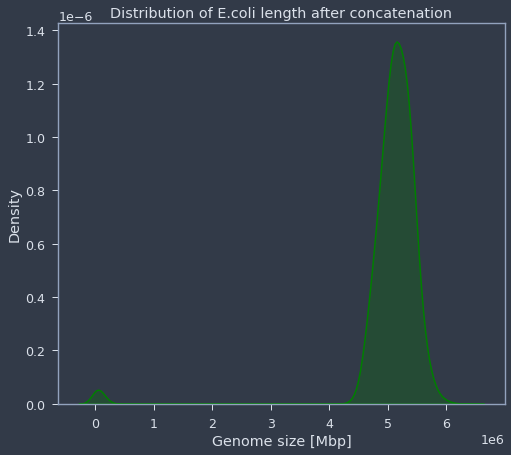

In [126]:
plt.figure()
plt.title('Distribution of E.coli length after concatenation')
plt.xlabel('Genome size [Mbp]')
sns.kdeplot(subset_asm,shade=True,linewidth=1.5,color='green')
plt.show()

/home/bz_gcp/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


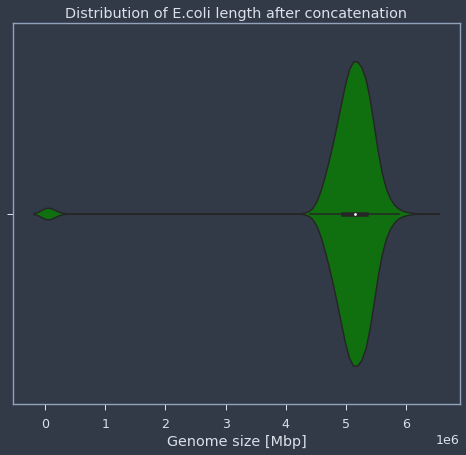

In [129]:
plt.figure()
plt.title('Distribution of E.coli length after concatenation')
plt.xlabel('Genome size [Mbp]')
sns.violinplot(subset_asm,color='green',linewidth=1.5)
plt.show()

In [135]:
import numpy as np
pd.DataFrame({'mean':[round(np.mean(subset_asm)/1e6,2)],'std': [round(np.std(subset_asm)/1e6,2)]},index=['E.coli'])

,mean,std
E.coli,5.07,0.66


From the distribution we can see that concatenation of all assembly files per bacteria yield sequence longer than 4.6 Mbp by ~0.5 Mbp.\
Additionally we can see second mode present on the density plot in the range [0,0.25] Mbp. This mode has to be removed.\
For now i am going to try use this slighlt longer E.coli concatanated sequences, and see how Word2Vec is going ot respond to it.

# Word2Vec Training

In [2]:
genome = "../input/GCF_001048035.2_ERL103914_genomic.fna"
seq = ''
with open(genome,'r') as r: 
    for record in SeqIO.parse(r,'fasta'):
        seq = record.seq

In [18]:
def get_kmers_from_seqs(seq, length = 24):
    nucleotides = {"A", "C", "T", "G"}
    kmer_seq = " ".join([sequence[x : x + length] for x in range(len(sequence) - length + 1)
            if len(set(sequence[x : x + length]).difference(nucleotides))==0])
    return kmer_seq

In [19]:
kmers = get_kmers_from_seqs(str(seq))

In [17]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
%time model =Word2Vec([kmers.split()])

2021-07-10 11:26:01,821 : INFO : collecting all words and their counts
2021-07-10 11:26:01,822 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-07-10 11:26:02,605 : INFO : collected 4096 word types from a corpus of 4758446 raw words and 1 sentences
2021-07-10 11:26:02,606 : INFO : Creating a fresh vocabulary
2021-07-10 11:26:02,621 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 4096 unique words (100.0%% of original 4096, drops 0)', 'datetime': '2021-07-10T11:26:02.620981', 'gensim': '4.0.1', 'python': '3.8.5 (default, Sep  4 2020, 07:30:14) \n[GCC 7.3.0]', 'platform': 'Linux-5.4.0-1046-gcp-x86_64-with-glibc2.10', 'event': 'prepare_vocab'}
2021-07-10 11:26:02,621 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 4758446 word corpus (100.0%% of original 4758446, drops 0)', 'datetime': '2021-07-10T11:26:02.621911', 'gensim': '4.0.1', 'python': '3.8.5 (default, Sep  4 2020, 07:30:14) \n[GCC 7.3.0]', 'platform':

CPU times: user 1.27 s, sys: 189 ms, total: 1.45 s
Wall time: 1.44 s


In [15]:
kmers.split()[0]

'GTGTCA'

In [16]:
model.wv.most_similar(kmers.split()[0])

[('TTACCT', 0.31725436449050903),
 ('TATTAA', 0.309436559677124),
 ('AACCGA', 0.30347490310668945),
 ('CTCTGA', 0.30186134576797485),
 ('TGATGA', 0.29212871193885803),
 ('CCCTCG', 0.2882496118545532),
 ('TCTTGG', 0.2879343628883362),
 ('TACTTT', 0.286830872297287),
 ('CATGGT', 0.2776031494140625),
 ('TGCGCA', 0.2743334174156189)]